# preprocessing

In [2]:
!git clone https://github.com/ItamarBerger/TabularDS

fatal: destination path 'TabularDS' already exists and is not an empty directory.


In [3]:
# load dataset
import pandas as pd
data = pd.read_csv('/content/TabularDS/final_project/code/data/online_retail.csv')
# data = retails.copy()

In [4]:
# retails.head()
# print(len(retails))
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#Apriori for rule mining

In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.dropna(subset=['InvoiceNo', 'Description'], inplace=True)

transactions = data.groupby('InvoiceNo')['Description'].apply(list).tolist()

In [8]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert the transaction data into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets (min_support can be adjusted based on your needs)
frequent_itemsets = apriori(df, min_support=0.02, use_colnames=True)

# Generate association rules (min_threshold can be adjusted for confidence)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the results
print(rules)


                                          antecedents  \
0                         (ALARM CLOCK BAKELIKE RED )   
1                        (ALARM CLOCK BAKELIKE GREEN)   
2                       (RED RETROSPOT CHARLOTTE BAG)   
3                       (CHARLOTTE BAG PINK POLKADOT)   
4                         (CHARLOTTE BAG SUKI DESIGN)   
..                                                ...   
79  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
80  (GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...   
81                 (ROSES REGENCY TEACUP AND SAUCER )   
82                  (GREEN REGENCY TEACUP AND SAUCER)   
83                   (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents  antecedent support  \
0                        (ALARM CLOCK BAKELIKE GREEN)            0.044220   
1                         (ALARM CLOCK BAKELIKE RED )            0.040947   
2                       (CHARLOTTE BAG PINK POLKADOT)            0.042952   
3      

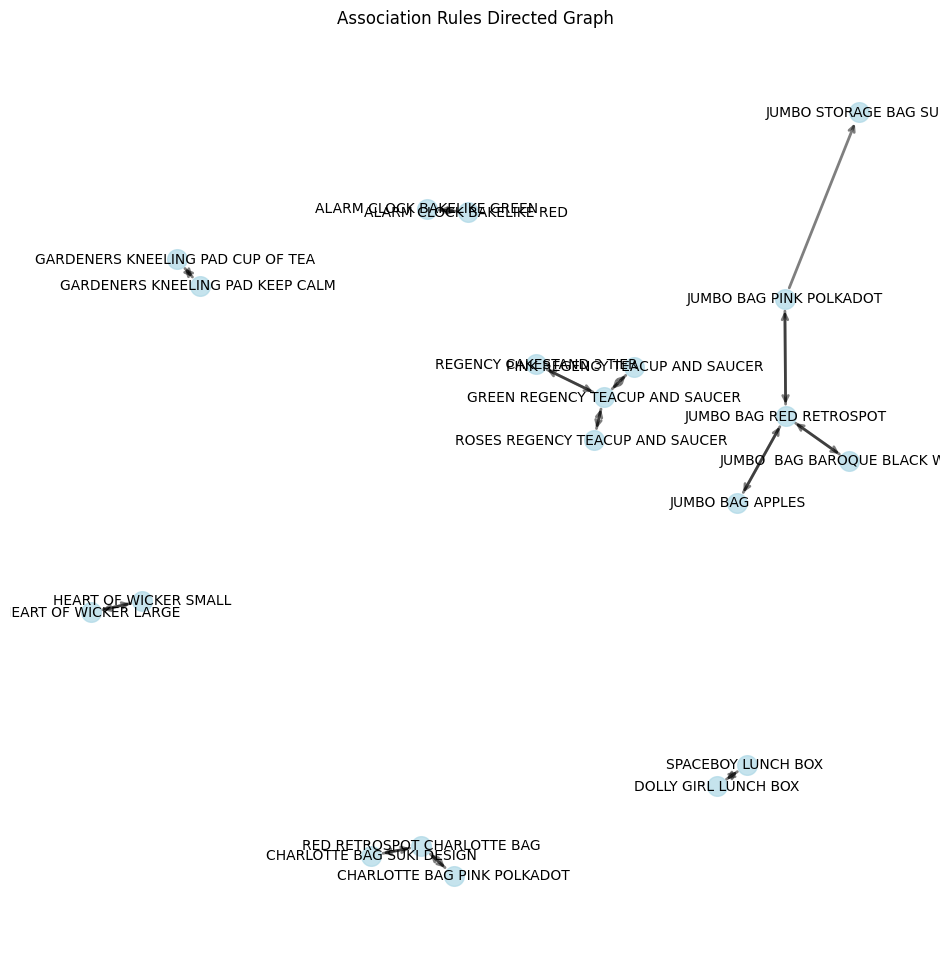

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Create a directed graph
G = nx.DiGraph()
narrow_rules = rules[0:25]
# Add nodes and directed edges
for _, rule in narrow_rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))

    # Add a directed edge from antecedent to consequent
    G.add_edge(antecedent, consequent, weight=rule['lift'], support=rule['support'], confidence=rule['confidence'])

# Draw the directed graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, iterations=20)  # Layout for the graph

# Draw the nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.5, arrowstyle='->', arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add edge labels (optional, if you want to display lift, confidence, or support)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Association Rules Directed Graph")
plt.axis('off')
plt.show()



In [29]:
import plotly.graph_objects as go
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Create a directed graph
G = nx.DiGraph()

# Add nodes and directed edges
for _, rule in rules.iterrows():
    antecedent = ', '.join(list(rule['antecedents']))
    consequent = ', '.join(list(rule['consequents']))

    # Add a directed edge from antecedent to consequent
    G.add_edge(antecedent, consequent, weight=rule['lift'], support=rule['support'], confidence=rule['confidence'])

# Get positions of nodes using a layout
pos = nx.spring_layout(G, k=0.3, iterations=20)

# Get edge and node information for Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_y.append(y0)
    edge_x.append(x1)
    edge_y.append(y1)

# Node positions
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create hover text for nodes (empty text for default)
hover_text = [node for node in G.nodes()]

# Create the plotly figure
fig = go.Figure()

# Add directed edges with arrows
fig.add_trace(go.Scatter(x=edge_x, y=edge_y,
                         line=dict(width=0.5, color='gray'),
                         hoverinfo='none',
                         mode='lines',
                         textposition="top center",
                         showlegend=False,
                         line_shape='linear',
                         # Arrowhead settings
                         marker=dict(symbol='arrow-bar', angleref='previous', size=10)))

# Add nodes to the plot
fig.add_trace(go.Scatter(x=node_x, y=node_y,
                         mode='markers',
                         hoverinfo='text',  # This ensures text shows on hover only
                         hovertext=hover_text,  # Set hovertext to show item names on hover
                         marker=dict(color='skyblue', size=10, line=dict(width=1, color='black'))))

# Add edge labels (optional: you can use lift or other metrics)
edge_labels = nx.get_edge_attributes(G, 'weight')
for edge, label in edge_labels.items():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(x=[(x0+x1)/2], y=[(y0+y1)/2],
                             text=[f'Lift: {label:.2f}'],
                             mode='text',
                             showlegend=False))

# Update layout settings for better visualization
fig.update_layout(title="Association Rules Directed Graph (Interactive)",
                  showlegend=False,
                  hovermode='closest',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False))

# Show the plot
fig.show()



ValueError: 
    Invalid value of type 'builtins.str' received for the 'symbol' property of scatter.marker
        Received value: 'arrow-bar'

    The 'symbol' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            [0, '0', 'circle', 100, '100', 'circle-open', 200, '200',
            'circle-dot', 300, '300', 'circle-open-dot', 1, '1',
            'square', 101, '101', 'square-open', 201, '201',
            'square-dot', 301, '301', 'square-open-dot', 2, '2',
            'diamond', 102, '102', 'diamond-open', 202, '202',
            'diamond-dot', 302, '302', 'diamond-open-dot', 3, '3',
            'cross', 103, '103', 'cross-open', 203, '203',
            'cross-dot', 303, '303', 'cross-open-dot', 4, '4', 'x',
            104, '104', 'x-open', 204, '204', 'x-dot', 304, '304',
            'x-open-dot', 5, '5', 'triangle-up', 105, '105',
            'triangle-up-open', 205, '205', 'triangle-up-dot', 305,
            '305', 'triangle-up-open-dot', 6, '6', 'triangle-down',
            106, '106', 'triangle-down-open', 206, '206',
            'triangle-down-dot', 306, '306', 'triangle-down-open-dot',
            7, '7', 'triangle-left', 107, '107', 'triangle-left-open',
            207, '207', 'triangle-left-dot', 307, '307',
            'triangle-left-open-dot', 8, '8', 'triangle-right', 108,
            '108', 'triangle-right-open', 208, '208',
            'triangle-right-dot', 308, '308',
            'triangle-right-open-dot', 9, '9', 'triangle-ne', 109,
            '109', 'triangle-ne-open', 209, '209', 'triangle-ne-dot',
            309, '309', 'triangle-ne-open-dot', 10, '10',
            'triangle-se', 110, '110', 'triangle-se-open', 210, '210',
            'triangle-se-dot', 310, '310', 'triangle-se-open-dot', 11,
            '11', 'triangle-sw', 111, '111', 'triangle-sw-open', 211,
            '211', 'triangle-sw-dot', 311, '311',
            'triangle-sw-open-dot', 12, '12', 'triangle-nw', 112,
            '112', 'triangle-nw-open', 212, '212', 'triangle-nw-dot',
            312, '312', 'triangle-nw-open-dot', 13, '13', 'pentagon',
            113, '113', 'pentagon-open', 213, '213', 'pentagon-dot',
            313, '313', 'pentagon-open-dot', 14, '14', 'hexagon', 114,
            '114', 'hexagon-open', 214, '214', 'hexagon-dot', 314,
            '314', 'hexagon-open-dot', 15, '15', 'hexagon2', 115,
            '115', 'hexagon2-open', 215, '215', 'hexagon2-dot', 315,
            '315', 'hexagon2-open-dot', 16, '16', 'octagon', 116,
            '116', 'octagon-open', 216, '216', 'octagon-dot', 316,
            '316', 'octagon-open-dot', 17, '17', 'star', 117, '117',
            'star-open', 217, '217', 'star-dot', 317, '317',
            'star-open-dot', 18, '18', 'hexagram', 118, '118',
            'hexagram-open', 218, '218', 'hexagram-dot', 318, '318',
            'hexagram-open-dot', 19, '19', 'star-triangle-up', 119,
            '119', 'star-triangle-up-open', 219, '219',
            'star-triangle-up-dot', 319, '319',
            'star-triangle-up-open-dot', 20, '20',
            'star-triangle-down', 120, '120',
            'star-triangle-down-open', 220, '220',
            'star-triangle-down-dot', 320, '320',
            'star-triangle-down-open-dot', 21, '21', 'star-square',
            121, '121', 'star-square-open', 221, '221',
            'star-square-dot', 321, '321', 'star-square-open-dot', 22,
            '22', 'star-diamond', 122, '122', 'star-diamond-open',
            222, '222', 'star-diamond-dot', 322, '322',
            'star-diamond-open-dot', 23, '23', 'diamond-tall', 123,
            '123', 'diamond-tall-open', 223, '223',
            'diamond-tall-dot', 323, '323', 'diamond-tall-open-dot',
            24, '24', 'diamond-wide', 124, '124', 'diamond-wide-open',
            224, '224', 'diamond-wide-dot', 324, '324',
            'diamond-wide-open-dot', 25, '25', 'hourglass', 125,
            '125', 'hourglass-open', 26, '26', 'bowtie', 126, '126',
            'bowtie-open', 27, '27', 'circle-cross', 127, '127',
            'circle-cross-open', 28, '28', 'circle-x', 128, '128',
            'circle-x-open', 29, '29', 'square-cross', 129, '129',
            'square-cross-open', 30, '30', 'square-x', 130, '130',
            'square-x-open', 31, '31', 'diamond-cross', 131, '131',
            'diamond-cross-open', 32, '32', 'diamond-x', 132, '132',
            'diamond-x-open', 33, '33', 'cross-thin', 133, '133',
            'cross-thin-open', 34, '34', 'x-thin', 134, '134',
            'x-thin-open', 35, '35', 'asterisk', 135, '135',
            'asterisk-open', 36, '36', 'hash', 136, '136',
            'hash-open', 236, '236', 'hash-dot', 336, '336',
            'hash-open-dot', 37, '37', 'y-up', 137, '137',
            'y-up-open', 38, '38', 'y-down', 138, '138',
            'y-down-open', 39, '39', 'y-left', 139, '139',
            'y-left-open', 40, '40', 'y-right', 140, '140',
            'y-right-open', 41, '41', 'line-ew', 141, '141',
            'line-ew-open', 42, '42', 'line-ns', 142, '142',
            'line-ns-open', 43, '43', 'line-ne', 143, '143',
            'line-ne-open', 44, '44', 'line-nw', 144, '144',
            'line-nw-open', 45, '45', 'arrow-up', 145, '145',
            'arrow-up-open', 46, '46', 'arrow-down', 146, '146',
            'arrow-down-open', 47, '47', 'arrow-left', 147, '147',
            'arrow-left-open', 48, '48', 'arrow-right', 148, '148',
            'arrow-right-open', 49, '49', 'arrow-bar-up', 149, '149',
            'arrow-bar-up-open', 50, '50', 'arrow-bar-down', 150,
            '150', 'arrow-bar-down-open', 51, '51', 'arrow-bar-left',
            151, '151', 'arrow-bar-left-open', 52, '52',
            'arrow-bar-right', 152, '152', 'arrow-bar-right-open', 53,
            '53', 'arrow', 153, '153', 'arrow-open', 54, '54',
            'arrow-wide', 154, '154', 'arrow-wide-open']
      - A tuple, list, or one-dimensional numpy array of the above

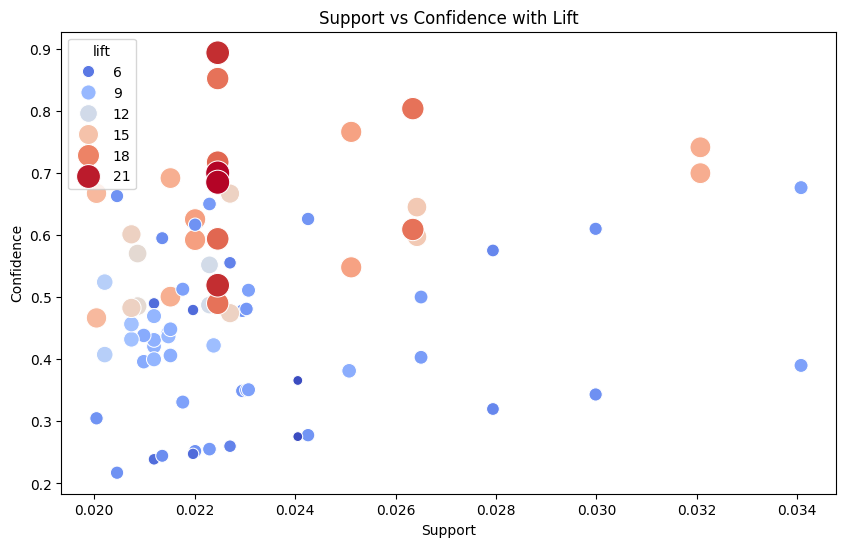

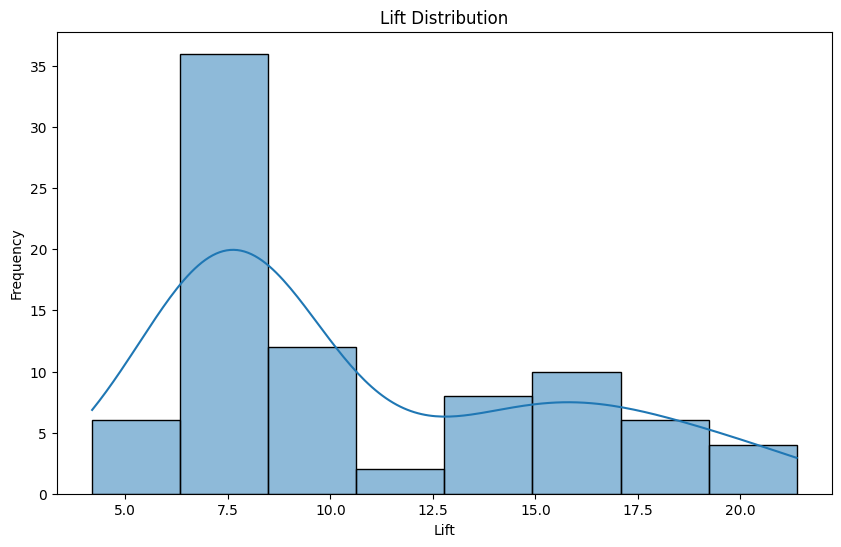

In [15]:
import seaborn as sns

# Plot support vs confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='support', y='confidence', data=rules, hue='lift', palette='coolwarm', size='lift', sizes=(50, 300))
plt.title("Support vs Confidence with Lift")
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

# Plot lift distribution
plt.figure(figsize=(10, 6))
sns.histplot(rules['lift'], kde=True)
plt.title("Lift Distribution")
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Convert transactions to a DataFrame
itemset = set(item for transaction in retails for item in transaction)
data_dict = [{item: (item in transaction) for item in itemset} for transaction in retails]
df = pd.DataFrame(data_dict)

# Apply Apriori algorithm
min_support = 0.5  # Minimum support threshold
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)



In [ ]:
# Generate association rules
min_confidence = 0.03  # Minimum confidence threshold
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)

print("Frequent Itemsets:")
print(frequent_itemsets)
print("\nAssociation Rules:")
print(rules)

In [ ]:
# Filter interesting rules
interesting_rules = rules[(rules['confidence'] >= 0.8) & (rules['lift'] > 1.2) & (rules['support'])]
print("\nMost Interesting Association Rules:")
print(interesting_rules.head(100))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

item_sim_matrix = cosine_similarity(df_onehot.T)  # Item-item similarity
item_sim_df = pd.DataFrame(item_sim_matrix, index=df_onehot.columns, columns=df_onehot.columns)


In [ ]:
# perform item-based CF for rule mining
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_item_ratings(invoice_items, item_sim_df):
    """
    Calculate predicted rating for items not in the invoice.
    Rating(Item X) = sum(sim(Item X, item_in_invoice)) / sum(similarities)
    """
    scores = {}
    norm_factor = 0

    for item in invoice_items:
        similar_items = item_sim_df[item].drop(index=invoice_items, errors="ignore")  # Remove existing items
        for sim_item, similarity in similar_items.items():
            scores[sim_item] = scores.get(sim_item, 0) + similarity  # Aggregate similarity scores
            norm_factor += similarity  # Normalize by sum of similarities

    if norm_factor == 0:
        return {}

    # Normalize scores
    for item in scores:
        scores[item] /= norm_factor

    return scores

In [ ]:
from tqdm.notebook import tqdm
threshold = 0.2  # Min rating for an item to be considered

rules = []
for invoice in tqdm(df_onehot.index,desc="Processing Raiting"):
    existing_items = df_onehot.columns[df_onehot.loc[invoice] == 1].tolist()
    predicted_ratings = compute_item_ratings(existing_items, item_sim_df)

    # Select items with rating above threshold
    recommended_items = {item for item, score in predicted_ratings.items() if score > threshold}

    if recommended_items:
        rules.append((set(existing_items), recommended_items))  # Format: {A, B, C} → {D, F}

rules_df = pd.DataFrame(rules, columns=["Antecedent", "Consequent"])


In [ ]:
# compute Confidence and Lift
def compute_rule_metrics(rules_df, df_onehot):
    total_invoices = len(df_onehot)
    metrics = []

    for _, row in rules_df.iterrows():
        antecedent = row["Antecedent"]
        consequent = row["Consequent"]

        support_A = (df_onehot[list(antecedent)].sum(axis=1) == len(antecedent)).mean()
        support_B = (df_onehot[list(consequent)].sum(axis=1) == len(consequent)).mean()
        support_A_B = ((df_onehot[list(antecedent)].sum(axis=1) == len(antecedent)) &
                       (df_onehot[list(consequent)].sum(axis=1) == len(consequent))).mean()

        confidence = support_A_B / support_A if support_A > 0 else 0
        lift = confidence / support_B if support_B > 0 else 0
        interestingness = confidence * lift  # Tradeoff metric

        metrics.append((antecedent, consequent, confidence, lift, interestingness))

    return pd.DataFrame(metrics, columns=["Antecedent", "Consequent", "Confidence", "Lift", "Interestingness"])

rules_eval_df = compute_rule_metrics(rules_df, df_onehot)




In [ ]:
# Select Top 100 Most Interesting Rules
top_100_rules = rules_eval_df.sort_values(by="Interestingness", ascending=False).head(100)
print(top_100_rules)